# Denoising by euclidean distance

Given points in Euclidean space with the metric $e(x, y) = \|x - y\|_2 = \left (\sum_i (x_i - x_j)^2 \right )^{1/2}$

We explore the properties of the distance $d_z(x, y) = \left (\sum_z \| e(x, z) - e(z, y) \|_2^2 \right )^{1/2}$

(2500, 2)


<AxesSubplot: >

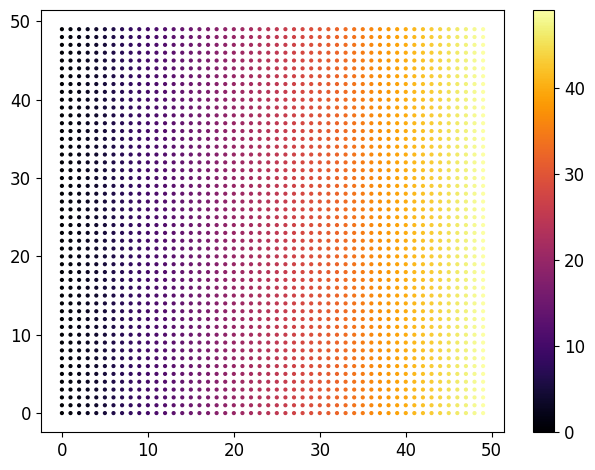

In [35]:
import numpy as np
import scprep
np.random.seed(42)
x = np.random.rand(1000, 2)
x = np.array(np.meshgrid(np.arange(64),np.arange(64))).reshape(2, -1).T
noise = np.random.randn(*x.shape)
print(x.shape)
scprep.plot.scatter2d(x, c=x[:,0])

In [36]:
z = embed_MDS(x)

<AxesSubplot: >

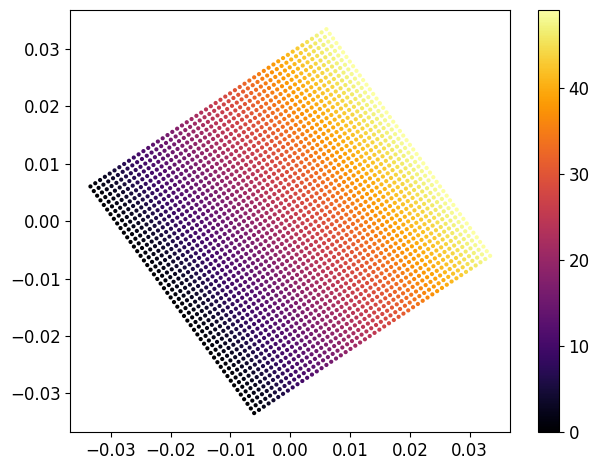

In [37]:
scprep.plot.scatter2d(z, x[:,0])

<AxesSubplot: >

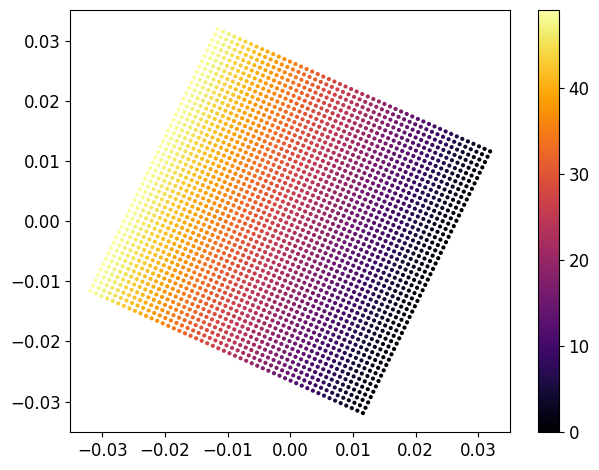

In [38]:
z2 = embed_MDS(squareform(pdist(x)), distance_metric=None)
scprep.plot.scatter2d(z2, x[:,0])

<AxesSubplot: >

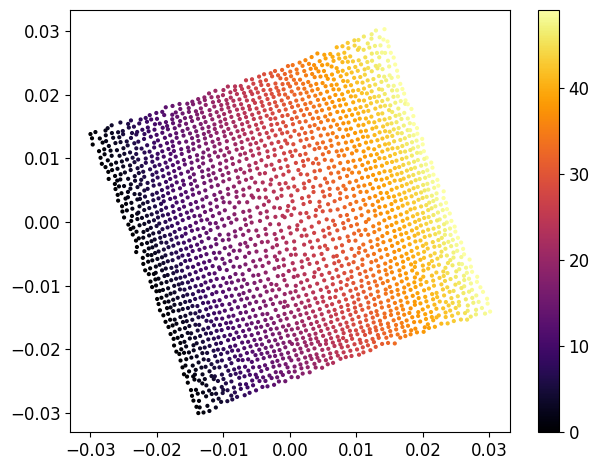

In [39]:
z3 = embed_MDS(squareform(pdist(x)), distance_metric="euclidean")
scprep.plot.scatter2d(z3, x[:,0])

<AxesSubplot: >

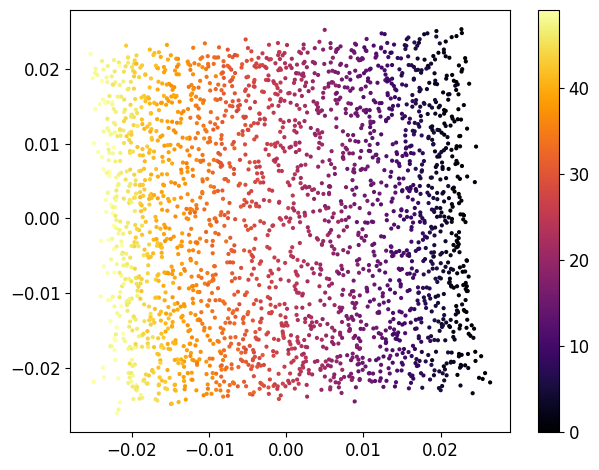

In [42]:
z3 = embed_MDS(squareform(pdist(x+noise)), distance_metric="euclidean")
scprep.plot.scatter2d(z3, x[:,0])

In [57]:
true = squareform(pdist(x))
dist_noise = np.random.randn(*true.shape) * 10
denoise = squareform(pdist(x)) + dist_noise
double_denoise = squareform(pdist(squareform(pdist(x)) + dist_noise))

np.mean(np.abs(true - denoise)), np.mean(np.abs(true - double_denoise))

(7.980797516867358, 1039.6992396056917)

In [61]:
denoise = squareform(pdist(x+10*noise))
double_denoise = squareform(pdist(squareform(pdist(x+10*noise))))


In [62]:
np.mean((true - denoise)**2), np.mean((true - double_denoise)**2)

(188.8862885084472, 939462.698589307)

In [63]:
np.corrcoef(true.flatten(), denoise.flatten())

array([[1.        , 0.60934651],
       [0.60934651, 1.        ]])

In [64]:
np.corrcoef(true.flatten(), double_denoise.flatten())

array([[1.        , 0.56863853],
       [0.56863853, 1.        ]])

<AxesSubplot: >

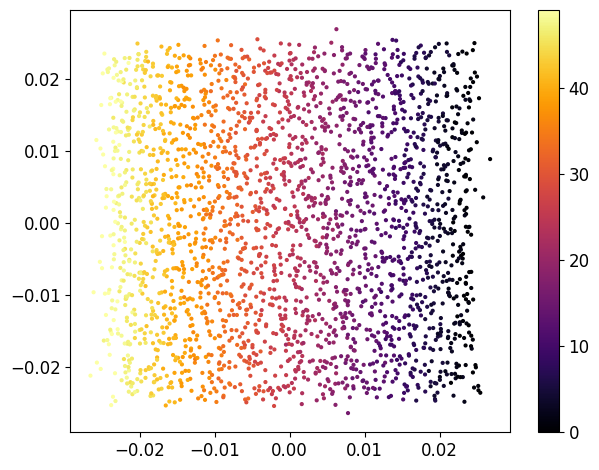

In [41]:
z2 = embed_MDS(squareform(pdist(x+noise)), distance_metric=None)
scprep.plot.scatter2d(z2, x[:,0])

In [19]:
from phate.mds import classic, smacof, sgd
from scipy.spatial.distance import pdist, squareform
import scipy
def embed_MDS(
    X,
    ndim=2,
    how="metric",
    distance_metric="euclidean",
    solver="sgd",
    n_jobs=1,
    seed=None,
    verbose=0,
):
    """Performs classic, metric, and non-metric MDS
    Metric MDS is initialized using classic MDS,
    non-metric MDS is initialized using metric MDS.
    Parameters
    ----------
    X: ndarray [n_samples, n_features]
        2 dimensional input data array with n_samples
    n_dim : int, optional, default: 2
        number of dimensions in which the data will be embedded
    how : string, optional, default: 'classic'
        choose from ['classic', 'metric', 'nonmetric']
        which MDS algorithm is used for dimensionality reduction
    distance_metric : string, optional, default: 'euclidean'
        choose from ['cosine', 'euclidean']
        distance metric for MDS
    solver : {'sgd', 'smacof'}, optional (default: 'sgd')
        which solver to use for metric MDS. SGD is substantially faster,
        but produces slightly less optimal results. Note that SMACOF was used
        for all figures in the PHATE paper.
    n_jobs : integer, optional, default: 1
        The number of jobs to use for the computation.
        If -1 all CPUs are used. If 1 is given, no parallel computing code is
        used at all, which is useful for debugging.
        For n_jobs below -1, (n_cpus + 1 + n_jobs) are used. Thus for
        n_jobs = -2, all CPUs but one are used
    seed: integer or numpy.RandomState, optional
        The generator used to initialize SMACOF (metric, nonmetric) MDS
        If an integer is given, it fixes the seed
        Defaults to the global numpy random number generator
    Returns
    -------
    Y : ndarray [n_samples, n_dim]
        low dimensional embedding of X using MDS
    """

    if how not in ["classic", "metric", "nonmetric"]:
        raise ValueError(
            "Allowable 'how' values for MDS: 'classic', "
            "'metric', or 'nonmetric'. "
            "'{}' was passed.".format(how)
        )
    if solver not in ["sgd", "smacof"]:
        raise ValueError(
            "Allowable 'solver' values for MDS: 'sgd' or "
            "'smacof'. "
            "'{}' was passed.".format(solver)
        )

    # MDS embeddings, each gives a different output.
    if distance_metric is None:
        X_dist = X
    else:
        X_dist = squareform(pdist(X, distance_metric))

    # initialize all by CMDS
    Y_classic = classic(X_dist, n_components=ndim, random_state=seed)
    if how == "classic":
        return Y_classic

    # metric is next fastest
    if solver == "sgd":
        try:
            # use sgd2 if it is available
            Y = sgd(X_dist, n_components=ndim, random_state=seed, init=Y_classic)
            if np.any(~np.isfinite(Y)):
                _logger.warning("Using SMACOF because SGD returned NaN")
                raise NotImplementedError
        except NotImplementedError:
            # sgd2 currently only supports n_components==2
            Y = smacof(
                X_dist,
                n_components=ndim,
                random_state=seed,
                init=Y_classic,
                metric=True,
            )
    elif solver == "smacof":
        Y = smacof(
            X_dist, n_components=ndim, random_state=seed, init=Y_classic, metric=True
        )
    else:
        raise RuntimeError
    if how == "metric":
        # re-orient to classic
        _, Y, _ = scipy.spatial.procrustes(Y_classic, Y)
        return Y

In [171]:
from sklearn.datasets import make_swiss_roll
np.random.seed(42)
x, t = make_swiss_roll(2000)
x[:,1] *= 3
twod = np.stack([x[:, 1], t], axis=1)

/home/mila/a/alexander.tong/.conda/envs/trajectory-inference/lib/python3.10/site-packages/scprep/plot/utils.py:99: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


<Axes3DSubplot: >

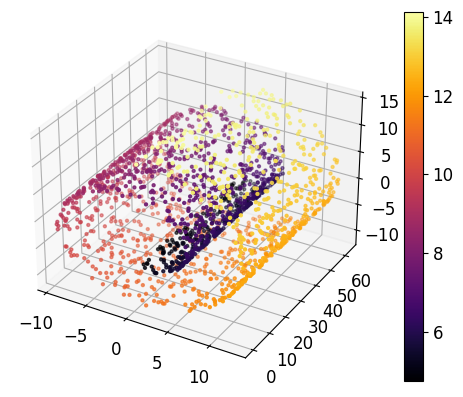

In [172]:
scprep.plot.scatter3d(x, c=t)

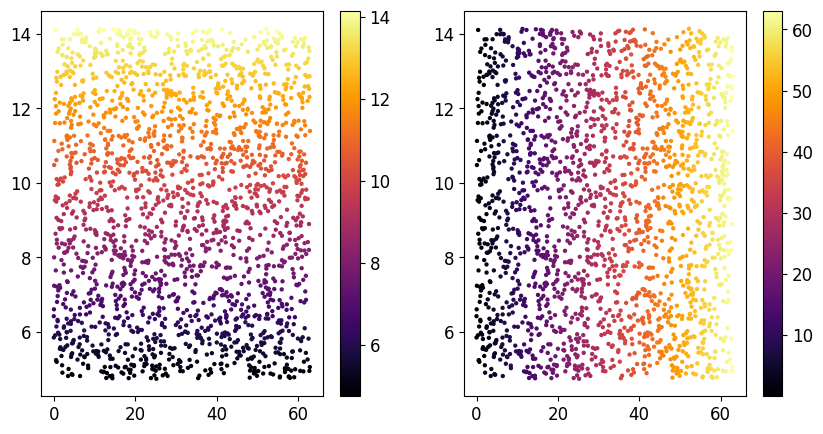

In [173]:
plot2d(twod)

In [174]:
def plot2d(embed):
    fig, axes = plt.subplots(1, 2, figsize=(10,5))
    scprep.plot.scatter2d(embed, c=t, ax=axes[0])
    scprep.plot.scatter2d(embed, c=x[:,1], ax=axes[1])

Calculating PHATE...
  Running PHATE on 2000 observations and 3 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.01 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.03 seconds.
  Calculating optimal t...
    Automatically selected t = 23
  Calculated optimal t in 2.35 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 2.17 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 3.23 seconds.
Calculated PHATE in 7.79 seconds.


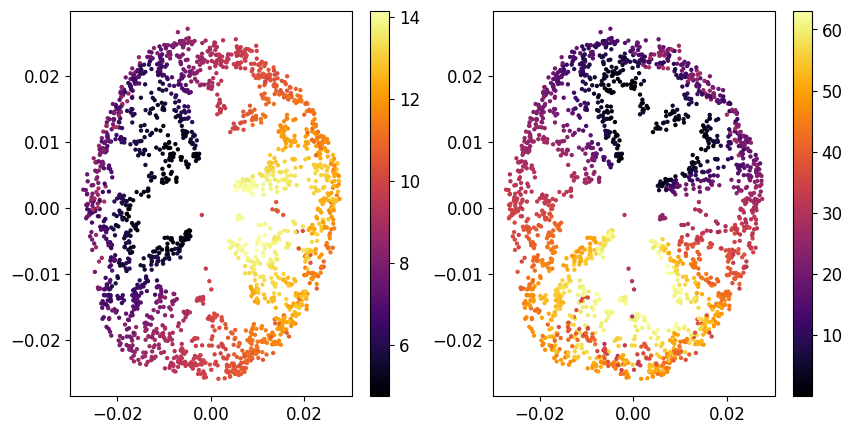

In [175]:
import phate
import matplotlib.pyplot as plt
phate_op = phate.PHATE(random_state=42)
phate_embed = phate_op.fit_transform(x)
plot2d(phate_embed)

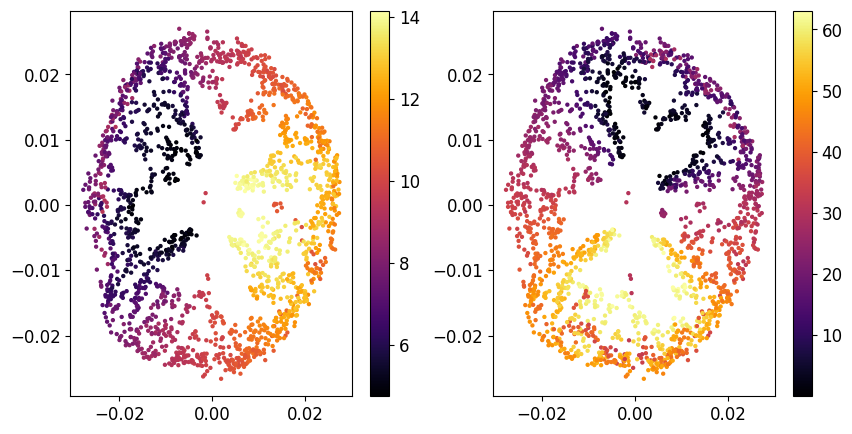

In [176]:
mds_x = embed_MDS(phate_op.diff_potential)
plot2d(mds_x)

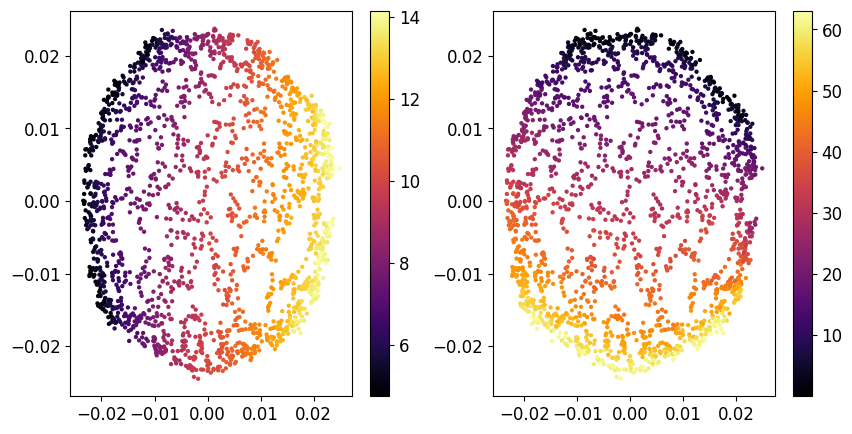

In [177]:
mds_x = embed_MDS((phate_op.diff_potential + phate_op.diff_potential.T) * (1 - np.eye(2000)), distance_metric=None)
plot2d(mds_x)

In [182]:
K = phate_op.graph._kernel.toarray()
D = K.sum(axis=1)
P = phate_op.graph._diff_op.toarray()
Pt = np.linalg.matrix_power(P, 22)

In [183]:
assert np.allclose(P, (np.diag(1 / D) @ K))
assert np.allclose(P, phate_op.diff_op)
assert np.allclose(-np.log(Pt + 1e-7), phate_op.diff_potential)

AssertionError: 

In [ ]:
# Get the symmetric version of P and Pt Pt_sym = D^{0.5} @ Pt_rw @ D^{-0.5}

In [ ]:
Ptsym = np.diag(D ** 0.5) @ Pt @ np.diag(D ** -0.5)

In [ ]:
dp = -np.log(Ptsym + 1e-7)
dp = dp + dp.T

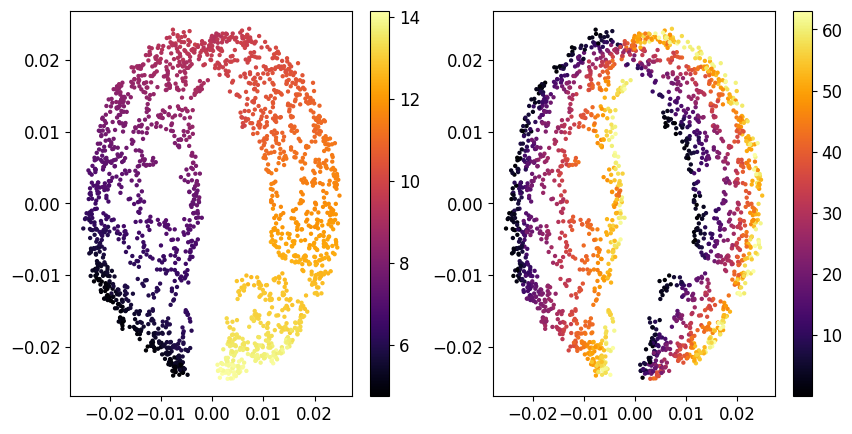

In [184]:
mds_x = embed_MDS(dp * (1 - np.eye(2000)), distance_metric=None)
plot2d(mds_x)